### Project EDDIE
## Correlation of Vegetation and Topographic Indexes at Local and Continental Scale

*This module is an adapted version of the module Remote Sensing of Plants and Topography in R with a slightly shifted focus on different landscape indexes by Conrad Jackisch in the EDDIE Faculty Mentoring Network Spring 2021. 16 April 2021. The original module was developed by Kyla M. Dahlin. 8 July 2020. Project EDDIE is supported by NSF 1821567. KMD was supported by NSF 1702379. NEON is a program sponsored by the National Science Foundation and operated under cooperative agreement by Battelle Memorial Institute. This material is based in part upon work supported by the National Science Foundation through the NEON Program.*

### Overall and Specific Questions
How do landscape and vegetation indexes correlate at local and continental scale?

1) Which topographic indexes are correlated with vegetation height and greenness in the Southern California foothills? 
2) How does correlation change in stratified subsets of the data? 
3) Do these local relationships persist across the U.S.? 
4) Do these relationships follow any macroscale geographic patterns?
 
### Learning Objectives
- Employ methods for terrain delineation and topographic indexes for land surface analyses.
- Visualize multivariate correlations of landscape indexes and vegetation growth and fitness. 
- Develop hypotheses about topography-vegetation correlation (and non-correlation) and test these hypotheses in a scripted application to data from other NEON sites. 
- Analyze and visualize spatial raster data in R, moving between making maps and doing non-spatial statistical tests.
- Consider macroscale (continental scale) patterns of relationships between topography and vegetation.
- Reflect the perceptual assumptions in the employed analyses.

### Why this matters
At the global scale, we know that there is more above ground biomass near the equator than there is towards the poles. At the local scale, however, many different environmental gradients (e.g. topography, geology, hydrology) can influence plant growth. Within each of these environmental factors, there are many possible ways the gradients can be quantified. Understanding these environmental drivers is important because they are likely to change in the face of global change pressures - for example, as temperatures increase, plants may become greener at higher elevations, indicating either an increase in growth of the existing plants or a change in the plant species. Similarly, plants of the same species tend to grow larger under optimal growth conditions. In this module, you will learn how to assess whether plant greenness and height are correlated with topographic variables (elevation, slope, aspect) at one location, and then across many locations in the U.S.



This Python version of the module leads through three main activities:

**Prep:** Discussion of introductory presentation and materials. You should have some familiarity with the available data and the intended analyses. You should have some comfort with this jupyter notebook and all required modules readily set up.

**Activity A:** We use the normalized difference vegetation index (NDVI) as proxy for vegetation activity and calculate vegetation height based on the difference between a digital elevation map (DEM) and a digital terrain map (DTM) (last and first hit envelope of an airborne LiDAR scan, respectively). We calculate a set of possible decribing factors from the DEM (slope, aspect, flow accumulation, topographic wetness index (TWI), and northness (cosine of aspect)). Based on the visualization, generate hypotheses about the most likely driver(s) of vegetation growth.

**Activity B:** Analyze correlations between topographic variables and vegetation variables more closely based on discrete and joint distribution plots. At the end of this activity, you will decide on one metric and gradient combination which will be used to explore a set of NEON sites across the US to determine the extent to which the local pattern applies at large scales.

**Activity C:** Apply your proposed correlation metric to the full data set in order i) to evaluate your proposed metric at different sites and ii) to analyse how local vegetation patterns manifest at larger scale, too.

## Preparation

In [ ]:
#run only if packages are missing (usually at first encounter):
#https://trac.osgeo.org/osgeo4w/

## either use pip:
#!pip install geopandas seaborn rasterio earthpy whitebox

## or use conda:
#!conda config --add channels conda-forge
#!conda config --set channel_priority strict
#!conda install geopandas, rasterio, earthpy, seaborn
#!pip install whitebox

In [3]:
## The required NEON data is here:
#  https://d32ogoqmya1dw8.cloudfront.net/files/eddie/earthecosystems/eddieevents/workshops/module_development_2019/participant_workspace/module_development/all_neon_data.zip
#  Download and unzip to your working directory

In [1]:
## Import required modules to this notebook
%pylab inline
import glob
#import geopandas as gpd
import pandas as pd

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import whitebox
wbt = whitebox.WhiteboxTools()
print(wbt.version())

WhiteboxTools v1.4.0 by Dr. John B. Lindsay (c) 2017-2020

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See https://jblindsay.github.io/ghrg/WhiteboxTools/index.html
for more details.



## Activity A

In [3]:
#Since Whitebox GIS does not properly handle relative paths, define the folder working folder for Activity A as absolute path:
fo = '/Users/cojack/Documents/TUBAF/teaching/hydropedology/uebung/eddie_topoveg/CA_SOAP_2018/'
#fo = 'C:\\Benutzer\\bla\\hydropedologie\\........\\CA_SOAP_2018\\'
#fo = '/home/jovyan/CA_SOAP_2018/'
#This adds the respective file names:
fi_NDVI = glob.glob(fo+'*NDVI.tif')[0]
fi_DSM = glob.glob(fo+'*DSM.tif')[0]
fi_DTM = glob.glob(fo+'*DTM.tif')[0]

In [8]:
#Apply Whitebox GIS land surface index calculations
wbt.feature_preserving_smoothing(fi_DTM, fo+"smoothed.tif", filter=9)
wbt.breach_depressions(fo+"smoothed.tif", fo+"breached.tif")
wbt.d_inf_flow_accumulation(fo+"breached.tif", fo+"flow_accum.tif")
wbt.slope(fi_DTM, fo+'slope.tif')
wbt.aspect(fi_DTM, fo+'aspect.tif')
wbt.fd8_flow_accumulation(fi_DTM, fo+'sca.tif', out_type="specific contributing area")
wbt.wetness_index(fo+'sca.tif',fo+'slope.tif',fo+'wetness.tif')
#wbt.time_in_daylight(fi_DSM,'daylight.tif')

#You might think of more possible topographic indexes which might be of relevance.
#Check what is possible with Whitebox GIS: https://www.whiteboxgeo.com/user-manual/

./whitebox_tools --run="FeaturePreservingSmoothing" --dem='/Users/cojack/Documents/TUBAF/teaching/hydropedology/uebung/eddie_topoveg/CA_SOAP_2018/NEON_D17_SOAP_DP3_298000_4100000_DTM.tif' --output='/Users/cojack/Documents/TUBAF/teaching/hydropedology/uebung/eddie_topoveg/CA_SOAP_2018/smoothed.tif' --filter=9 --norm_diff=15.0 --num_iter=3 --max_diff=0.5 -v

*****************************************
* Welcome to FeaturePreservingSmoothing *
*****************************************
Reading data...
Calculating normal vectors: 0%
Calculating normal vectors: 1%
Calculating normal vectors: 2%
Calculating normal vectors: 3%
Calculating normal vectors: 4%
Calculating normal vectors: 5%
Calculating normal vectors: 6%
Calculating normal vectors: 7%
Calculating normal vectors: 8%
Calculating normal vectors: 9%
Calculating normal vectors: 10%
Calculating normal vectors: 11%
Calculating normal vectors: 12%
Calculating normal vectors: 13%
Calculating normal vectors: 14%
Calculating normal vectors: 1

0

In [4]:
#Load the raster maps:
with rio.open(fi_DTM) as src:
    dtm = src.read(1, masked=True)
    dtm_meta = src.profile

with rio.open(fi_DSM) as src:
    dsm = src.read(1, masked=True)
    dsm_meta = src.profile

with rio.open(fi_NDVI) as src:
    ndvi = src.read(1, masked=True)
    ndvi_meta = src.profile

with rio.open(fo+'sca.tif') as src:
    flowac = src.read(1, masked=True)
    flowac_meta = src.profile

with rio.open(fo+'wetness.tif') as src:
    wet = src.read(1, masked=True)
    wet_meta = src.profile

with rio.open(fo+'slope.tif') as src:
    slope = src.read(1, masked=True)
    slope_meta = src.profile

with rio.open(fo+'aspect.tif') as src:
    aspect = src.read(1, masked=True)
    aspect_meta = src.profile



In [5]:
#calculate canopy height model
chm = dsm - dtm

# the file can be exported as a new geotiff
with rio.open(fo+'lidar_chm.tif', 'w', **dsm_meta) as ff:
    ff.write(chm,1)

#calculate the hillshade for visualization
hillshade = es.hillshade(dtm)

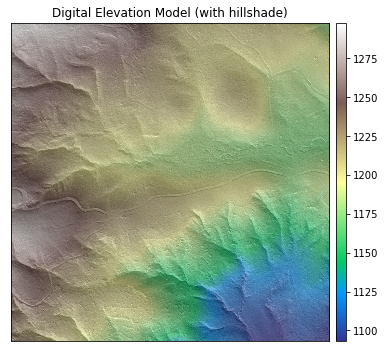

In [14]:
# Plot some maps of elevation, canopy height and NDVI
fig, ax1 = plt.subplots(figsize=(6,6),ncols=1)

# map of elevation model
ep.plot_bands(
    dtm,
    ax=ax1,
    cmap="terrain",
    title="Digital Elevation Model (with hillshade)",
)
ax1.imshow(hillshade, cmap="Greys", alpha=0.5)

fig.savefig(fo+'plot.pdf',bbox_inches='tight')

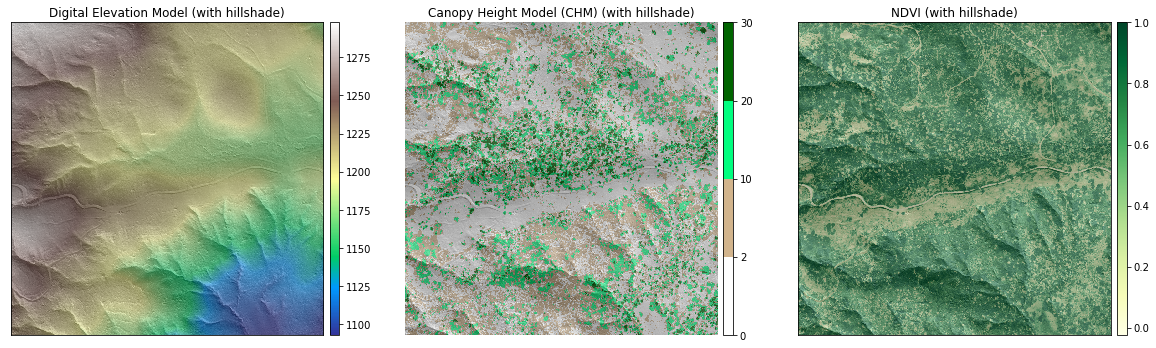

In [7]:
# Plot some maps of elevation, canopy height and NDVI
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 6),ncols=3)

# map of elevation model
ep.plot_bands(
    dtm,
    ax=ax1,
    cmap="terrain",
    title="Digital Elevation Model (with hillshade)",
)
ax1.imshow(hillshade, cmap="Greys", alpha=0.5)

# map of the canopy height
# Define the colors you want
cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)

chm_plot = ax2.imshow(chm, 
                     cmap=cmap, 
                     norm=norm)
ax2.set_title("Canopy Height Model (CHM) (with hillshade)")
ep.colorbar(chm_plot)
ax2.imshow(hillshade, cmap="Greys", alpha=0.5)
ax2.set_axis_off()

ep.plot_bands(
    ndvi,
    ax=ax3,
    cmap="YlGn",
    title="NDVI (with hillshade)",
)
ax3.imshow(hillshade, cmap="Greys", alpha=0.5)

plt.show()

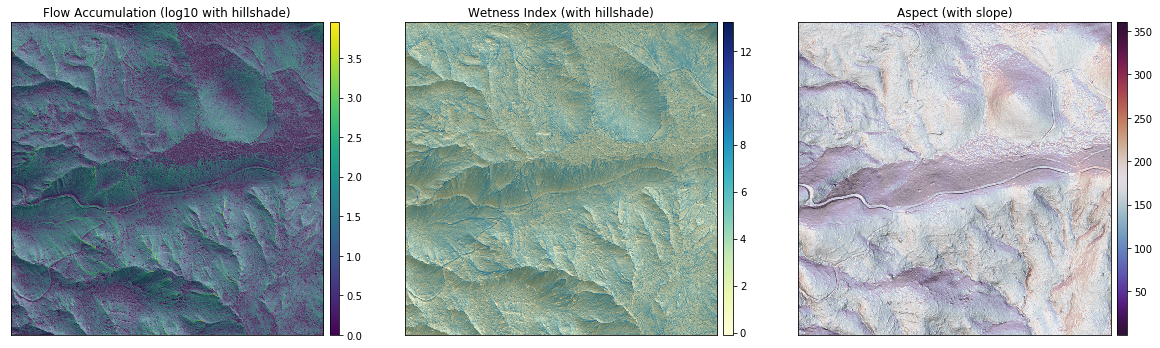

In [8]:
# Plot maps of possible factors
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 6),ncols=3)

# map of calulated flow accumulation
ep.plot_bands(
    np.log10(flowac),
    ax=ax1,
    cmap="viridis",
    title="Flow Accumulation (log10 with hillshade)",
)
ax1.imshow(hillshade, cmap="Greys", alpha=0.5)

# map of calulated wetness index
ep.plot_bands(
    wet,
    ax=ax2,
    cmap="YlGnBu",
    title="Wetness Index (with hillshade)",
)
ax2.imshow(hillshade, cmap="Greys", alpha=0.5)

# map of calulated aspect
ep.plot_bands(
    #np.cos(np.radians(aspect)),
    #cmap='viridis_r',
    #title="Northness (with slope)",
    aspect,
    cmap="twilight_shifted",
    title="Aspect (with slope)",
    ax=ax3,
)
ax3.imshow(slope*(255./slope.max()), cmap="Greys", alpha=0.7)

plt.show()


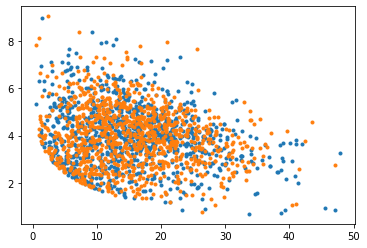

In [34]:
idx1 = np.random.randint(low=0,high=999999,size=1000)
idx2 = np.random.randint(low=0,high=999999,size=1000)
plot(slope.data.flatten()[idx1],wet.data.flatten()[idx1],'.')
plot(slope.data.flatten()[idx2],wet.data.flatten()[idx2],'.')

In [45]:
idx_baum = np.where(chm.flatten() > 5.5)[0]
len(idx_baum)

348402

Text(0, 0.5, 'twi')

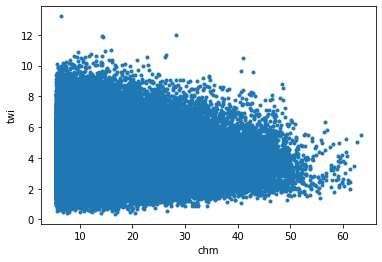

In [49]:
plot(chm.data.flatten()[idx_baum],wet.data.flatten()[idx_baum],'.')
xlabel('chm')
ylabel('twi')

Based on the visualizations, generate and discuss hypotheses about the most likely driver(s) of vegetation growth.

## Activity B

In [54]:
wet2 = wet
wet2[wet2.data<0.] = np.nan

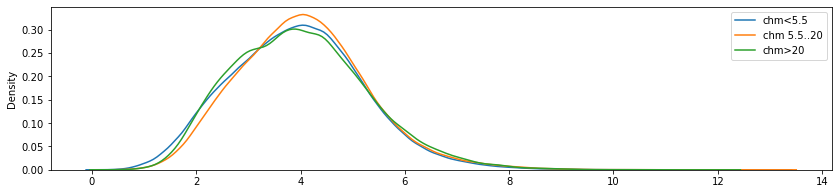

In [55]:
#Get familiar with the data
#use histograms to look at the different distributions and possible correlations

# This example plots the slope of the landscape in three elevation bands:
figsize(14,3)
sns.kdeplot(wet2.data.flatten()[chm.data.flatten()<5.5],label='chm<5.5')
sns.kdeplot(wet2.data.flatten()[(chm.data.flatten()>=5.5) & (chm.data.flatten()<=20.)],label='chm 5.5..20')
sns.kdeplot(wet2.data.flatten()[chm.data.flatten()>20.],label='chm>20')
legend()

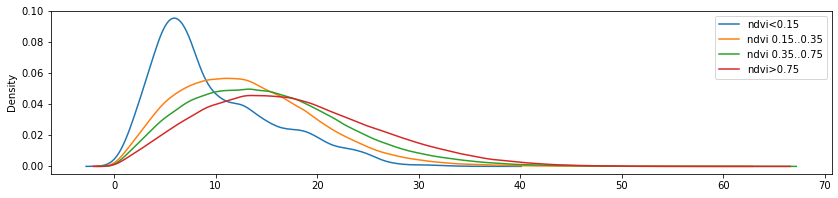

In [62]:
#Get familiar with the data
#use histograms to look at the different distributions and possible correlations

# This example plots the slope of the landscape in three elevation bands:
figsize(14,3)
sns.kdeplot(slope.data.flatten()[ndvi.data.flatten()<0.15],label='ndvi<0.15')
sns.kdeplot(slope.data.flatten()[(ndvi.data.flatten()>=0.15) & (ndvi.data.flatten()<=0.35)],label='ndvi 0.15..0.35')
sns.kdeplot(slope.data.flatten()[(ndvi.data.flatten()>=0.35) & (ndvi.data.flatten()<=0.75)],label='ndvi 0.35..0.75')
sns.kdeplot(slope.data.flatten()[ndvi.data.flatten()>0.75],label='ndvi>0.75')
legend()

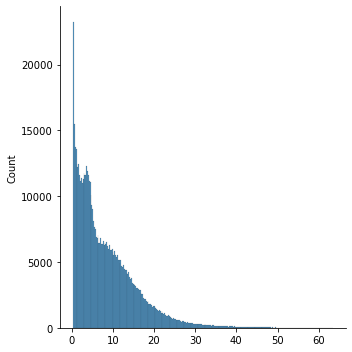

In [14]:
sns.displot(chm.data.flatten()[chm.data.flatten()>0.3])

Text(27.0, 0.5, 'slope')

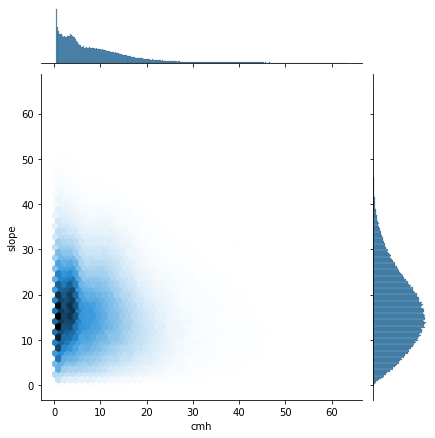

In [18]:
# Since we have to look at combined distributions, it is worthwhile to check jointplots:
# This example get the index for all cells with an elevation above 1250 m and plots slope against ndvi.

figsize(10,10)
#idx = (dtm.data.flatten()>=1170) & (dtm.data.flatten()<1250)
idx = chm.data.flatten()>0.3
sns.jointplot(x = chm.data.flatten()[idx], y = slope.data.flatten()[idx], kind = 'hex')
xlabel('cmh')
ylabel('slope')

Use the examples above and construct your hypothesis for an index that explains vegetation at the training location. Pls. note that elevation is an absolute value. Discuss your hypothesis.

## Activity C

In [53]:
fos = glob.glob(fo+'../*_201*')
correlations = np.zeros(len(fos))
mean_chm = np.zeros(len(fos))
mean_ndvi = np.zeros(len(fos))
mean_minmaxelev = np.zeros(len(fos))
i = 0

for fo in fos:
    try:
        fi_NDVI = glob.glob(fo+'/*NDVI.tif')[0]
        fi_DSM = glob.glob(fo+'/*DSM.tif')[0]
        fi_DTM = glob.glob(fo+'/*DTM.tif')[0]
        wbt.slope(fi_DTM, fo+'/slope.tif')

        with rio.open(fi_DTM) as src:
            dtm = src.read(1, masked=True)
            dtm_meta = src.profile

        with rio.open(fi_DSM) as src:
            dsm = src.read(1, masked=True)
            dsm_meta = src.profile
        
        #calculate canopy height model
        chm = dsm - dtm
        
        with rio.open(fi_NDVI) as src:
            ndvi = src.read(1, masked=True)
            ndvi_meta = src.profile
        
        with rio.open(fo+'/slope.tif') as src:
            slope = src.read(1, masked=True)
            slope_meta = src.profile
        
        #a = slope.data.flatten() - ndvi.data.flatten()
        #RMSE = np.sqrt(np.mean(np.square(a)))
        correlations[i] = np.corrcoef(slope.data.flatten(), ndvi.data.flatten())[0,1]
        mean_chm[i] = np.mean(chm.data.flatten())
        mean_ndvi[i] = np.mean(ndvi.data.flatten())
        mean_minmaxelev[i] = np.max(dtm.data.flatten()) - np.min(dtm.data.flatten())
        i += 1
    except:
        correlations[i] = np.nan
        i += 1


./whitebox_tools --run="Slope" --dem='/Users/cojack/Documents/TUBAF/teaching/hydropedology/uebung/eddie_topoveg/CA_SOAP_2018/../AK_TOOL_2018/NEON_D18_TOOL_DP3_403000_7618000_DTM.tif' --output='/Users/cojack/Documents/TUBAF/teaching/hydropedology/uebung/eddie_topoveg/CA_SOAP_2018/../AK_TOOL_2018/slope.tif' --units=degrees -v

********************
* Welcome to Slope *
********************
Reading data...
Performing analysis: 0%
Performing analysis: 1%
Performing analysis: 2%
Performing analysis: 3%
Performing analysis: 4%
Performing analysis: 5%
Performing analysis: 6%
Performing analysis: 7%
Performing analysis: 8%
Performing analysis: 9%
Performing analysis: 10%
Performing analysis: 11%
Performing analysis: 12%
Performing analysis: 13%
Performing analysis: 14%
Performing analysis: 15%
Performing analysis: 16%
Performing analysis: 17%
Performing analysis: 18%
Performing analysis: 19%
Performing analysis: 20%
Performing analysis: 21%
Performing analysis: 22%
Performing analysis: 23%
Perf

Text(0, 0.5, 'mean NDVI')

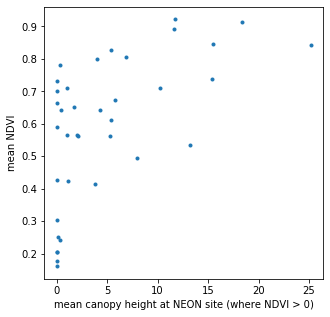

In [56]:
figsize(5,5)
plot(mean_chm[mean_ndvi>0],mean_ndvi[mean_ndvi>0],'.')
xlabel('mean canopy height at NEON site (where NDVI > 0)')
ylabel('mean NDVI')

## Helper

In [36]:
# a calculated map can be exported as a new geotiff file like this
# this example exports the calculated canopy height model *chm* to the file *lidar_chm.tif*
with rio.open(fo+'lidar_chm.tif', 'w', **dsm_meta) as ff:
    ff.write(chm,1)